In [208]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from multiprocessing import Pool
import tensorflow as tf
from tensorflow.python.ops import nn


py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))

#from packages import *
#from parameters import *

from model_DL import *
from functions import *
from metrics import *
from DNN_metrics import *
from data_generator import *
from loss_function import *
from optimization import *



tf.device('GPU:1') 

### Channel gain creation

First, you can choose the type of channel to perform the simulations. To do this, simply select the type by entering the number of the desired channel type 

In [2]:
h_PP, h_PR, h_RP, h_SS, h_SR, h_RS, h_SP, h_PS = channel_type() # train data-type


        1. Channel gain with gaussian fading [1]
        2. Channel gain with Anne model [2]
        3. Channel gain with Uniform distribution[3] 
        4. Channel gain with Rician fading [4]
        5. Channel gain with Nakagami fading [5]
        6.Exit/Quit
        
Select channel gain
2
Channel gain created


In [3]:
t_h_PP, t_h_PR, t_h_RP, t_h_SS, t_h_SR, t_h_RS, t_h_SP, t_h_PS = channel_type() # test data-type


        1. Channel gain with gaussian fading [1]
        2. Channel gain with Anne model [2]
        3. Channel gain with Uniform distribution[3] 
        4. Channel gain with Rician fading [4]
        5. Channel gain with Nakagami fading [5]
        6.Exit/Quit
        
Select channel gain
2
Channel gain created


### Dataset
Create the dataset and save it on a specific path

1 - data size must be fixed

In [17]:
Nbr_train = int(1E6)

Nbr_test = int(2E5) 

#outfile = 'Dataset/' # choose your path 

In [27]:
# # choose your directory path  
project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""
  
# Path
try : 

    path = os.path.join(parent_dir, project_sub_path)
    os.mkdir(path)
    print("Directory '% s' created" % project_sub_path)
except FileExistsError : 
    pass
    


## Save the data

In [28]:
# # choose your directory path  
project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""

np.savez(os.path.join(parent_dir,project_sub_path,'dataset_train_GF.npz'),
         h_PP=h_PP,
         h_PS=h_PS,
         h_PR=h_PR,
         h_SP=h_SP,
         h_SS=h_SS,
         h_SR=h_SR,
         h_RP=h_RP,
         h_RS=h_RS
         ) 

print("\n training set generation finished")


 training set generation finished


In [29]:
np.savez(os.path.join(parent_dir,project_sub_path,'dataset_val_GF.npz'),
         h_PP=t_h_PP,
         h_PS=t_h_PS,
         h_PR=t_h_PR,
         h_SP=t_h_SP,
         h_SS=t_h_SS,
         h_SR=t_h_SR,
         h_RP=t_h_RP,
         h_RS=t_h_RS,
         ) 

print("\n training set generation finished")


 training set generation finished


## Loading the data

In [30]:
Nbr_test_bruteforce = 10000


project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""
### Train ###
#dataset_train_Anne
dataset_train = np.load(os.path.join(parent_dir,project_sub_path,'dataset_train_anne.npz'))

h_11_tr = dataset_train['h_PP']
h_12_tr = dataset_train['h_PS']
h_1R_tr = dataset_train['h_PR']
h_21_tr = dataset_train['h_SP']
h_22_tr = dataset_train['h_SS']
h_2R_tr = dataset_train['h_SR']
h_R1_tr = dataset_train['h_RP']
h_R2_tr = dataset_train['h_RS']


#x_train_input = np.stack([h_11_tr, h_12_tr, h_1R_tr, h_21_tr, h_22_tr, h_2R_tr, h_R1_tr, h_R2_tr], axis=1)
x_train = np.stack([h_R1_tr, h_11_tr, h_2R_tr, h_1R_tr, h_22_tr, h_R2_tr, h_21_tr, h_12_tr], axis=1)





### VAL ###
project_sub_path = "Dataset_VF"
  
# Parent Directory path
parent_dir = ""
#dataset_val_Anne

dataset_test = np.load(os.path.join(parent_dir,project_sub_path,'dataset_val_anne.npz'))

h_11_test = dataset_test['h_PP'][:Nbr_test_bruteforce]
h_12_test = dataset_test['h_PS'][:Nbr_test_bruteforce]
h_1R_test = dataset_test['h_PR'][:Nbr_test_bruteforce]
h_21_test = dataset_test['h_SP'][:Nbr_test_bruteforce]
h_22_test = dataset_test['h_SS'][:Nbr_test_bruteforce]
h_2R_test = dataset_test['h_SR'][:Nbr_test_bruteforce]
h_R1_test = dataset_test['h_RP'][:Nbr_test_bruteforce]
h_R2_test = dataset_test['h_RS'][:Nbr_test_bruteforce]

x_test = np.stack([h_R1_test, h_11_test, h_2R_test, h_1R_test, h_22_test, h_R2_test, h_21_test, h_12_test], axis=1)



# Train DNN without noise 

In [ ]:
metrics = [Achievable_Rate(tau), QoS_Violation(tau), Primary_Achievable_Rate_Degradation, Primary_ARD_Percentage(tau)] #, QoS_mean_DF, QoS_median_DF

VS = 0.2 # validation_split

Epochs = 1000 # Epochs number

BS = 4096 # batch_size

LD = 10**0.5

LR = 10**-4

model = get_model_DF(x_train, loss_DF_WN(LD,tau), metrics, 'sigmoid', custom_sigmoid, custom_sigmoid, LR)

history = model.fit(x_train, np.power(x_train, 2), epochs=Epochs, batch_size=BS, validation_data=(x_test, np.power(x_test, 2)))#validation_split = VS


# -------------- save weights ---------------#


    
# weights_model/gaussian_fading_model.h5
    
model.save('weights_model/GF_model.h5')
np.save('weights_model/GF_model',history.history)




## Useful functions

In [31]:
def noise_to_channels(X, channelID, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    '''
    Parameters : 
       
        test_set :  test set containing the H channels
    
        col : list of index for the specific column to add noise
    
    Returns:
    
        channel gain ndarray container of noisy channels 

    '''    
    
    var_X = np.var(X[:, channelID], axis=0, keepdims=True)
    
    noisy_gains = [] # list to store all the noisy H matrices with different level of noise variance
    for SNR_db in SNRs_db:
        
        SNR = np.power(10,SNR_db/10)
        noises = np.sqrt(var_X/SNR)*np.random.normal(0.0, 1.0, (X.shape[0], len(channelID)))
    
        X_noised = X.copy()
        X_noised[:, channelID] = X_noised[:, channelID] + noises
        noisy_gains.append(X_noised)

    return SNRs_db, np.asarray(noisy_gains, dtype="float32")
#-----------------------------------------------------------------------------------------#

def BF_A_squeeze(x):
    return BF_A(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])

def generate_benchmark(H_matrix): 
    '''
    bruteforce for H without noise
    '''
    with Pool() as p:
        BF_res =  p.map(BF_A_squeeze, np.power(H_matrix, 2))

    return np.squeeze(np.asarray(BF_res, dtype="float64"))

#-----------------------------------------------------------------------------------------#

def bruteforce_for_noisy_channels(BH_matrix):
    
    '''
    Compute bruteforce method for channel gain ndarray composed of noisy channels
    '''

    BF_res = [] # list containing channels and bruteforce results (Alpha,Pr,Ps) for each noisy matrix (0, 10^-1.5, 10^-1....) 
    
    
    for i in range(BH_matrix.shape[0]) :
        X = BH_matrix[i,:,:]
        
        temp_BF_res = generate_benchmark(X)
        
        BF_res.append(temp_BF_res)

        
    return np.asarray(BF_res, dtype="float64")


#-----------------------------------------------------------------------------------------#




## Bruteforce and data saving

In [20]:
# Get P and S channels index form dataset (h_R1, h_11, h_2R, h_1R, h_22, h_R2, h_21, h_12)

Primary_index = [0, 1, 6] 
Secondary_index = [3, 7]



## Noise for training set

In [21]:
noise_levels, X_train_noised = noise_to_channels(x_train, Primary_index)
X_train_noised_anne = 'Dataset_VF/X_train_noised_anne'
np.savez(X_train_noised_anne, X_train_noised)


In [6]:
#X_train_noised_GF = 'Dataset_VF/X_train_noised_anne'
X_train_noised_anne = 'Dataset_VF/X_train_noised_anne'



X_train_noised = np.load(X_train_noised_GF+".npz")
X_train_noised.files
X_train_noised = X_train_noised['arr_0']


## Noise for test set

In [ ]:
# Get Noisy H-MATRIX with different noise variance

noise_levels, NH_MATRIX = noise_to_channels(x_test, Primary_index)

# Compute bruteforce for NH-MATRIX

BF_NG_MATRIX = bruteforce_for_noisy_channels(NH_MATRIX) 

# bruteforce for test_set without noise

BF_G_Benchmark = generate_benchmark(x_test) 

#----------------------------------Save data----------------------------------------------#

outfile_NH_MATRIX = 'Dataset_VF/NH_MATRIX_P_GF_v2'
np.savez(outfile_NH_MATRIX, NH_MATRIX)


outfile_BF_NG_MATRIX = 'Dataset_VF/BF_NG_MATRIX_P_GF_v2'
np.savez(outfile_BF_NG_MATRIX, BF_NG_MATRIX)


outfile_BF_G_Benchmark = 'Dataset_VF/BF_G_Benchmark_P_GF_v2'
np.savez(outfile_BF_G_Benchmark, BF_G_Benchmark)

## Load data

In [32]:
# First, load ... 
# useful for DNN prediction because DNN takes H as input 

outfile_NH_MATRIX = 'Dataset_VF/NH_MATRIX_P_Anne_v2'

NH_MATRIX = np.load(outfile_NH_MATRIX+".npz")
NH_MATRIX.files
NH_MATRIX = NH_MATRIX['arr_0']

# Noisy_H ==> NH_MATRIX

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation ...  because it containing (Alpha, Pr, Ps) 


outfile_BF_NG_MATRIX = 'Dataset_VF/BF_NG_MATRIX_P_Anne_v2'

dataset_test = np.load(outfile_BF_NG_MATRIX+".npz")
dataset_test.files
dataset_test = dataset_test['arr_0']

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation, because it containing G Matrix without noise 


outfile_BF_G_Benchmark = 'Dataset_VF/BF_G_Benchmark_P_Anne_v2'

dataset = np.load(outfile_BF_G_Benchmark+".npz")
dataset.files
dataset = dataset['arr_0']





# Part 2 

1) Bruteforce analysis 

2) DNN analysis

# Bruteforce analysis

## Secondary rate GAP

Useful functions for secondary rate GAP calculation

In [102]:

#-----------------------------------------------------------------------------------------#


def relative_avreage_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return (np.mean(X) - np.mean(Y))/(np.mean(Y))

def avreage_relative_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return np.mean((X-Y)/Y)

#-----------------------------------------------------------------------------------------#


def opportunistic_rate_for_noisy_channels(datas, labels):
    '''
    Parameters: 
        dataset : test_set
        labels : For DNN estimations
    '''
    H_matrix = []
    opportunistic_rate = []
    # create H_matrix ( without noise ) for each noise level labels
    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
        
    # calculate rate for the same H with different labels based on noise level
    for i,j in zip(H_matrix,labels) : 
        data , label = i[:,0:8], j[:,8:12]
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], np.sqrt(label[:,1]), np.sqrt(label[:,2]), np.sqrt(label[:,3]))
        opportunistic_rate.append(temp_rate)
        
    return np.asarray(opportunistic_rate, dtype="float64")



def plot_CSI_Imperfect_Stats(res_stats, plot_lab, x_lab, y_lab, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, res_stats, c = 'black',label= plot_lab)

    ax.grid()

    ax.scatter(SNRs_db[0],res_stats[0],label=r'$SNR=-10$',s=200,marker='v',linewidths=1)

    ax.scatter(SNRs_db[1],res_stats[1],label=r'$SNR=-5}$',s=200,marker='o',linewidths=1)

    ax.scatter(SNRs_db[2],res_stats[2],label=r'$SNR=0$',s=200,marker='D',linewidths=1)

    ax.scatter(SNRs_db[3],res_stats[3],label='$SNR=5$',s=200,marker='H',linewidths=1)

    ax.scatter(SNRs_db[4],res_stats[4],label='$SNR=10$',s=200,marker='d',linewidths=1)

    ax.scatter(SNRs_db[5],res_stats[5],label='$SNR=15$',s=200,marker='P',linewidths=1)

    ax.scatter(SNRs_db[6],res_stats[6],label='$SNR=20$',s=200,marker='<',linewidths=1)

    #ax.scatter(var[7],res_stats[7],label='$\sigma=10^{1.5}$',s=200,marker='>',linewidths=1)

    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(loc='best', fontsize=16)

    plt.xlabel(x_lab, fontsize=24) #'Noise variance','Percentage'
    plt.ylabel(y_lab, fontsize=24)
    #plt.xscale('log')
    

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/RAG_opportunistic_rate.pdf', bbox_inches='tight')


In [48]:
# dataset : channel gain without noise and bruteforce output parameters (Alpha,Pr,Ps)
# dataset_test : channel gain with noise and bruteforce output parameters (Alpha,Pr,Ps)
# Getting only (Alpha,Pr,Ps) from dataset_test to calculate rate in opportunistic_rate_for_noisy_channels function


db_bruteforce = opportunistic_rate_for_noisy_channels(dataset, dataset_test) 
# rate for H without noise
db_benchmark = rate(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3], dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], np.sqrt(dataset[:,9]), np.sqrt(dataset[:,10]), np.sqrt(dataset[:,11]))

# List of relative gap between each noisy matrix and benchmark (BF results without noise)

db_gap = np.array([relative_avreage_gap(db_bruteforce[0,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[1,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[2,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[3,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[4,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[5,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[6,:,8], db_benchmark[:,8])])
#,\            relative_avreage_gap(db_bruteforce[7,:,8], db_benchmark[:,8])

#db_mean_gap = np.array([avreage_relative_gap(db_bruteforce[0,:,8], db_benchmark[:,8]),\
#                   avreage_relative_gap(db_bruteforce[1,:,8], db_benchmark[:,8]),\
#                   avreage_relative_gap(db_bruteforce[2,:,8], db_benchmark[:,8]),\
#                   avreage_relative_gap(db_bruteforce[3,:,8], db_benchmark[:,8]),\
#                   avreage_relative_gap(db_bruteforce[4,:,8], db_benchmark[:,8]),\
#                   avreage_relative_gap(db_bruteforce[5,:,8], db_benchmark[:,8]),\
#                   avreage_relative_gap(db_bruteforce[6,:,8], db_benchmark[:,8])
#                  ])

#db_mean_gap = db_mean_gap*100
db_gap = db_gap*100


# list of variance

#variance = [10**i for i in np.arange(-1.5,2,0.5)]
#varience = variance.insert(0, 0)
SNRs_db = [-10, -5, 0, 5, 10, 15, 20]


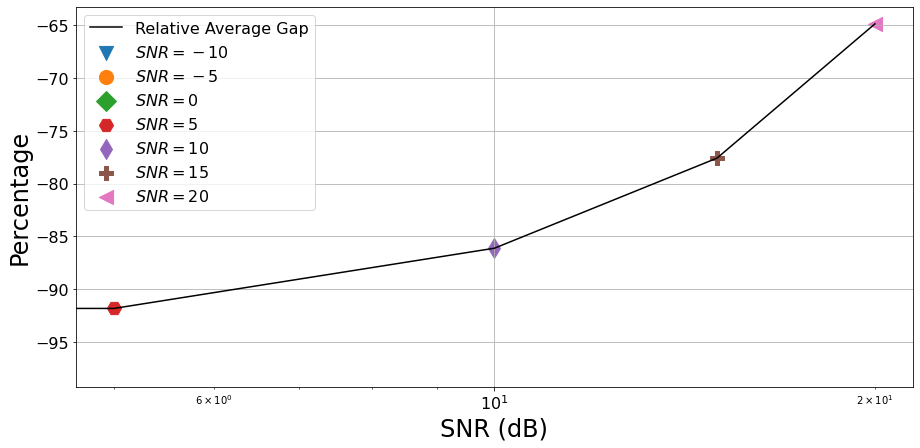

In [49]:
plot_CSI_Imperfect_Stats(db_gap, 'Relative Average Gap', 'SNR (dB)','Percentage')

#### Primary achievable rate degradation

In [210]:
def primary_rate(Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Alpha, Pr, Ps, Pp=10.0):
    """
      Parameters:
         Grp: 1D Array containing Alpha values.
         Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
         Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
         Alpha: 1D Array containing Alpha values.
         Pr: 1D Array containing Power of relay.
         Ps: 1D Array containing Power of secondary network.

      Returns:
         primary debit.

    """
    Rp = C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Ps*Pr*Alpha)+1))
    return Rp



def mean_max_outage_PARD(N_P_Rate, Max_P_Rate, tau = 0.25):
    '''
    N_PRate : Primary rate based on bruteforce output (Alpha, Pr, Ps) where BF is computed using noisy channels 
    Max_P_Rate : Primary rate without secondary users interference
    '''
    res = 1-(N_P_Rate/Max_P_Rate) # Compute of Delta
    
    #res = np.round(res,4)
    mean_res = np.nanmean(res) # Mean of Delta 
    max_res = np.max(res) # Max of Delta
    #res =  # Outage
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            mean_outage = np.nanmean(res[res>tau])
        except RuntimeWarning:
            mean_outage = 0
            
    outage = np.nanmean(res>tau)
    
    return mean_res, max_res, mean_outage, outage


def PARD_for_noisy_data(datas, labels, Pp=10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j[:,8:12]
        
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], np.sqrt(label[:,1]), np.sqrt(label[:,2]), np.sqrt(label[:,3]))
        
        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP
        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100

def plot_ARPD(mean_ARPD, maximum_ARPD, mean_outage_ARPD, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, maximum_ARPD, c = 'blue',label=r"$Max$",lw=2.5)
    ax.plot(SNRs_db, mean_ARPD, c = 'red',label=r"$Mean$",lw=2.5)
    ax.plot(SNRs_db, mean_outage_ARPD, c = 'gray',label=r"$Mean\; outage$",lw=2.5)

    ax.grid()

    xs = np.linspace(1, 10**1.5, 20)

    plt.hlines(y=25, xmin=-10, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')



    #ax.scatter(SNRs_db[0], maximum_ARPD[0],label=r'$SNR=-10$',s=200,marker='v',linewidths=1)

    #ax.scatter(SNRs_db[1], maximum_ARPD[1],label='$SNR=-5}$',s=200,marker='o',linewidths=1)

    #ax.scatter(SNRs_db[2], maximum_ARPD[2],label='$SNR=0$',s=200,marker='D',linewidths=1)

    #ax.scatter(SNRs_db[3], maximum_ARPD[3],label='$SNR=5$',s=200,marker='H',linewidths=1)

    #ax.scatter(SNRs_db[4], maximum_ARPD[4],label='$SNR=10$',s=200,marker='d',linewidths=1)

    #ax.scatter(SNRs_db[5], maximum_ARPD[5],label='$SNR=15$',s=200,marker='P',linewidths=1)

    #ax.scatter(SNRs_db[6], maximum_ARPD[6],label='$SNR=20$',s=200,marker='<',linewidths=1)



    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)



    ax.legend(loc='upper center', fontsize=16)

    plt.xlabel('SNR (dB)', fontsize=24)
    plt.ylabel('Primary network degradation (%)', fontsize=24)
    #plt.xscale('log')

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/PDD.pdf', bbox_inches='tight')



Mean_ARPD, Max_ARPD, Mean_Outage_ARPD, Outage_ARPD = PARD_for_noisy_data(dataset,dataset_test)



Max_ARPD

array([97.48718823, 99.96843191, 99.96579382, 99.49117281, 98.96447008,
       98.01577054, 96.66533555])

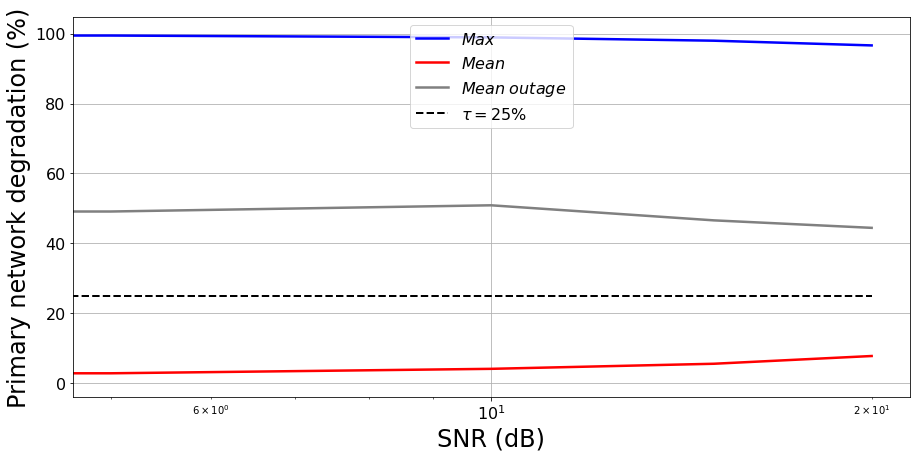

In [83]:
plot_ARPD(Mean_ARPD, Max_ARPD, Mean_Outage_ARPD)

# Outage   

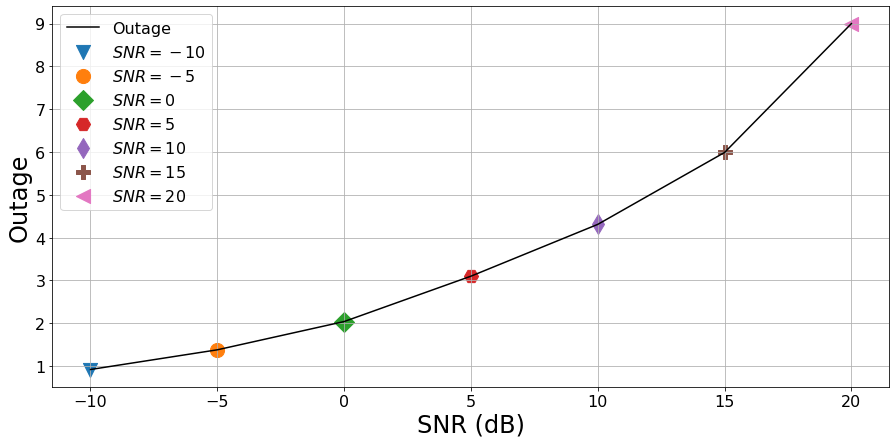

In [87]:

plot_CSI_Imperfect_Stats(Outage_ARPD, 'Outage', 'SNR (dB)','Outage')


# Part 3 : Deep Neural Network 

## Secondary rate GAP

In [89]:
def DNN_predictions(NH_MATRIX, mw_path, Lambda=10**0.5, tau = 0.25):
    '''
    NH_MATRIX : Noisy H matrix 
    '''
    final_predictions = []
   
  
    # selection of the desired model
    # A :  "Weights_Model/CSI imperfection/DNN_GF.h5"
    # B : Weights_Model/CSI imperfection/Lambda/LD_10_0_5_ANNE.h5
    # Load model
    model = tf.keras.models.load_model(mw_path, custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
    
    for i in NH_MATRIX : 
        data = i[:,0:8]
        temp_predictions = model.predict(data)
        final_predictions.append(temp_predictions)
        
    return np.asarray(final_predictions, dtype="float64")

def opportunistic_rate_for_noisy_channels_DNN(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")

def primary_degradation_for_noisy_data_DNN(datas, labels):
    final_pdd = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data, y_hat = i[:,0:8], j
        temp_pdd = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_pdd.append(temp_pdd)
        
    return np.asarray(final_pdd, dtype="float64")



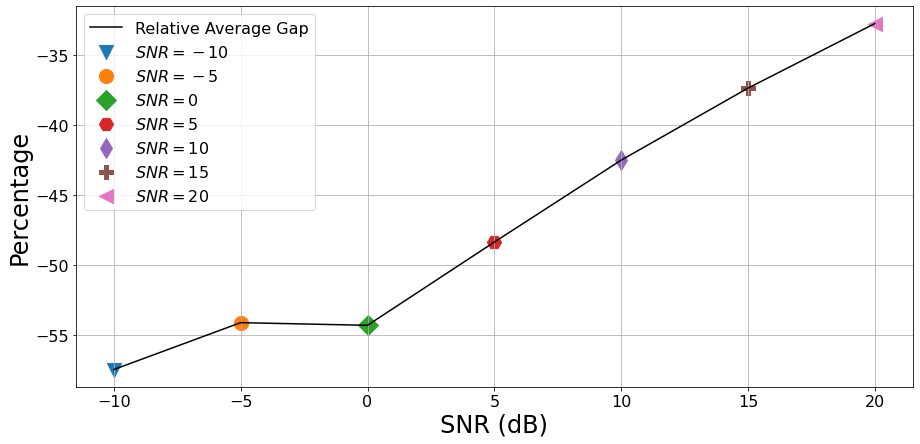

In [92]:
#"weights_model/gaussian_fading_model/anne_model.h5"
Model_Weight_Path = "weights_model/anne_model.h5"

DNN_pred = DNN_predictions(NH_MATRIX, Model_Weight_Path)
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)
db_benchmark = rate(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3], dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], np.sqrt(dataset[:,9]), np.sqrt(dataset[:,10]), np.sqrt(dataset[:,11]))


db_gap_DNN = np.array([relative_avreage_gap(db_DNN[0,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[1,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[2,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[3,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[4,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[5,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[6,:,8], db_benchmark[:,8])])
#,\
#                       relative_avreage_gap(db_DNN[7,:,8], db_benchmark[:,8])


#ax.plot(variance, db_gap, c = 'blue',label='BF')

db_gap_DNN = db_gap_DNN*100

plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')

In [22]:
db_gap_DNN 

array([-97.81425632, -97.0466103 , -94.62716912, -91.93618392,
       -86.22345523, -77.7564345 , -65.23560609])

## Primary achievable rate degradation

In [99]:
def PARD_for_noisy_data_DNN(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1], label[:,2])

        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100




Mean_ARPD_DNN, Max_ARPD_DNN, Mean_Outage_ARPD_DNN, Outage_ARPD_DNN = PARD_for_noisy_data_DNN(dataset, DNN_pred)



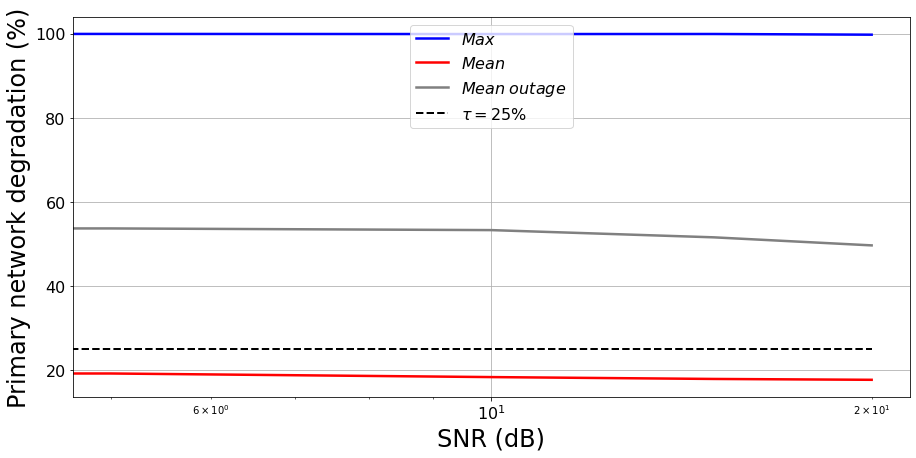

In [100]:
plot_ARPD(Mean_ARPD_DNN, Max_ARPD_DNN, Mean_Outage_ARPD_DNN)

# Outage

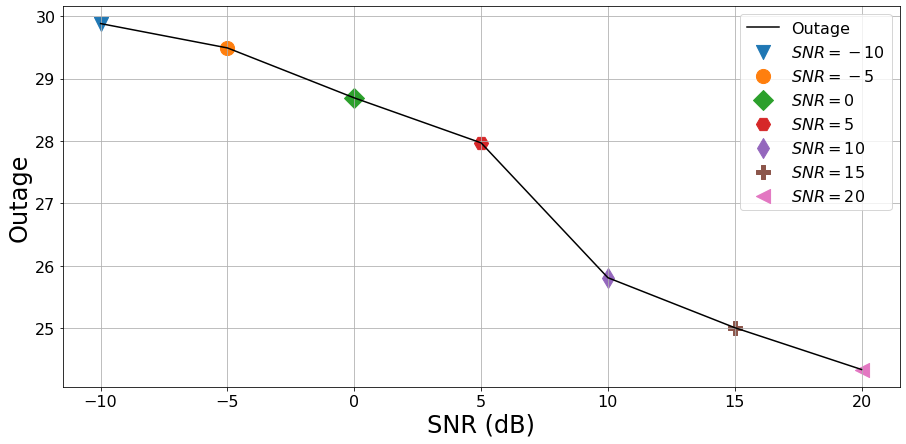

In [103]:

plot_CSI_Imperfect_Stats(Outage_ARPD_DNN, 'Outage', 'SNR (dB)','Outage')



# Training DNN with different noise levels

## Stopped here !!! need to retrain the network with SNR instead of variance noise...

In [ ]:
def DNN_for_noisy_channels(X_noised_train, hyperparameters, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    #X_noised_train, X_noised_val,hyperparameters, noise_levels = [0, 10**-1.5, 10**-1, 10**-0.5, 1, 10**0.5, 10**1, 10**1.5]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_DNN_results = []
    
    ind = 0 
    
    for x_n_train in X_noised_train : 
        
        model = get_model_DF(x_n_train, loss_DF_WN(hyperparameters[0], hyperparameters[1]), hyperparameters[2], 'sigmoid', custom_sigmoid, custom_sigmoid, hyperparameters[3])

        history = model.fit(x_n_train, np.power(x_n_train, 2), epochs=hyperparameters[4], batch_size=hyperparameters[5], validation_split=hyperparameters[6])#validation_split = VS
        
        model.save('Weights_Model/CSI imperfection/'+str(SNRs_db[ind])+'.h5')
        np.save('Weights_Model/CSI imperfection/'+str(SNRs_db[ind]),history.history)
        
        ind+=1
        
tau = 0.25

metrics = [Achievable_Rate(tau), QoS_Violation(tau), Primary_Achievable_Rate_Degradation, Primary_ARD_Percentage(tau)] #, QoS_mean_DF, QoS_median_DF

VS = 0.2 # validation_split

Epochs = 500 # Epochs number

BS = 4096 # batch_size

LD = 10**0.5

LR = 10**-4

tau = 0.25
#Nbr_train = int(1E6)


hyperparameters = [LD, tau, metrics, LR, Epochs, BS, VS]
DNN_for_noisy_channels(X_train_noised[2:,:Nbr_train,:], hyperparameters)




In [27]:
X_train_noised[3:7,:Nbr_train,:].shape

(4, 1000000, 8)

In [26]:
Nbr_train

1000000

In [110]:
def plot_history_noised_DNN(path_to_history, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    loss, val_loss = [], []
    for item in SNRs_db:
        history = np.load(path_to_history+str(item)+'.npy',allow_pickle='TRUE').item()
        loss.append(history['loss'][490:])
        val_loss.append(history['val_loss'][490:])
    return loss, val_loss
loss_history, val_loss_history = plot_history_noised_DNN('Weights_Model/CSI imperfection/')    


In [111]:
len(loss_history)

7

Text(0, 0.5, 'Loss')

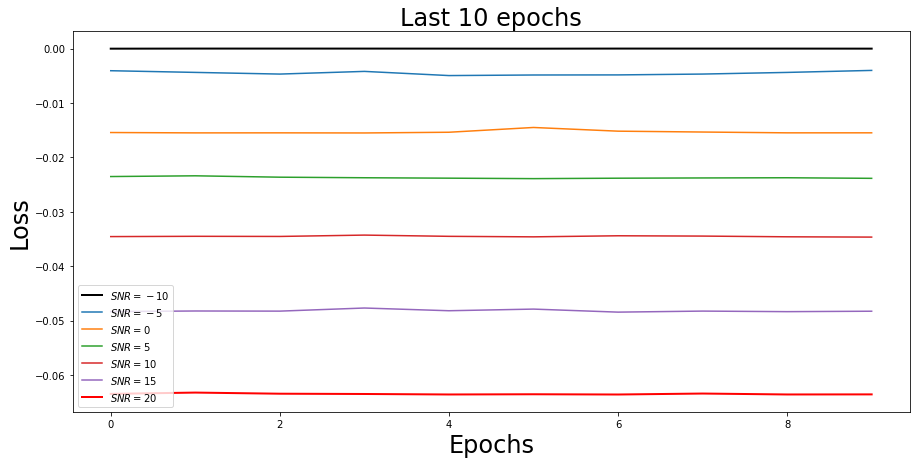

In [114]:
fig, ax = plt.subplots(1,figsize=(15,7))
plt.title("Last 10 epochs", fontsize=24)
ax.plot(np.arange(0,len(loss_history[0]),1), loss_history[0],label="$SNR=-10$",color='black',lw=2)
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[1],label=r"$SNR=-5$")
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[2],label=r"$SNR=0$")
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[3],label=r"$SNR=5$")
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[4],label=r"$SNR=10$")
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[5],label=r"$SNR=15$")
ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[6],label=r"$SNR=20$",color='red',lw=2)
#ax.plot(np.arange(0,len(loss_history[1]),1), loss_history[7],label=r"$10^{1.5}$")

ax.legend(loc="best")
plt.xlabel("Epochs",fontsize=24)
plt.ylabel("Loss",fontsize=24)

Text(0, 0.5, 'Validation Loss')

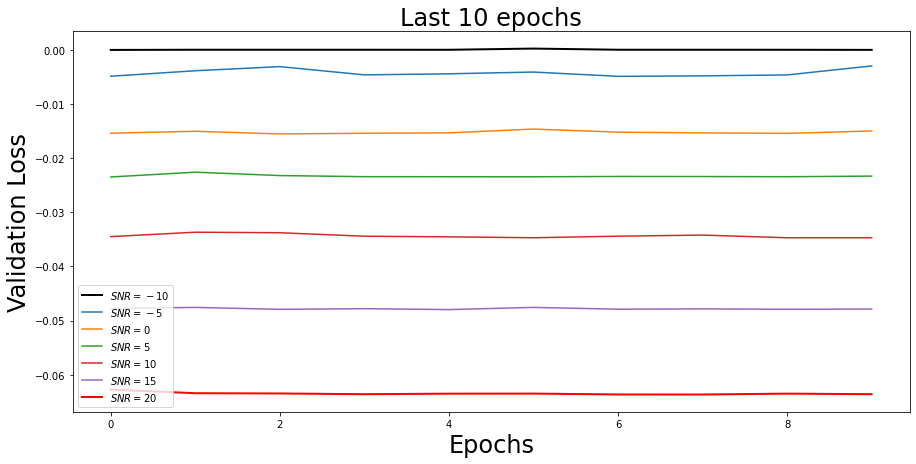

In [117]:
fig, ax = plt.subplots(1,figsize=(15,7))
plt.title("Last 10 epochs", fontsize=24)
ax.plot(np.arange(0,len(val_loss_history[0]),1), val_loss_history[0],label="$SNR=-10$",color='black',lw=2)
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[1],label=r"$SNR=-5$")
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[2],label=r"$SNR=0$")
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[3],label=r"$SNR=5$")
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[4],label=r"$SNR=10$")
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[5],label=r"$SNR=15$")
ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[6],label=r"$SNR=20$",color='red',lw=2)
#ax.plot(np.arange(0,len(val_loss_history[1]),1), val_loss_history[7],label=r"$10^{1.5}$")
ax.legend(loc="best")
plt.xlabel("Epochs",fontsize=24)
plt.ylabel("Validation Loss",fontsize=24)

In [124]:
def noised_DNN_pred(X, mw_path, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_predictions = []

    for noisy_X, snr_item in zip(X, SNRs_db):
        data = noisy_X[:,0:8]
        model = tf.keras.models.load_model(mw_path+str(snr_item)+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
        temp_predictions = model.predict(data)
        final_predictions.append(temp_predictions)
    
    return np.asarray(final_predictions, dtype="float64")

def noised_DNN_pred_V2(X, mw_path, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_predictions = []
    for snr_item in SNRs_db : 
        for noisy_X in X:
            data = noisy_X[:,0:8]
            model = tf.keras.models.load_model(mw_path+str(snr_item)+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
            temp_predictions = model.predict(data)
            final_predictions.append(temp_predictions)
    
    return np.asarray(final_predictions, dtype="float64")

DNN_pred = noised_DNN_pred_V2(NH_MATRIX, 'Weights_Model/CSI imperfection/')



In [125]:
DNN_pred.shape  #  7 :deep neural network for 7 SNR (7*7)=49

(49, 10000, 3)

In [158]:
def db_gap_Dnn(acheivable_rate, acheivable_rate_bruteforce, mul):
    
    db_gap_DNN = np.array([relative_avreage_gap(acheivable_rate[mul[0],:,8], acheivable_rate_bruteforce[:,8]),\
                       relative_avreage_gap(acheivable_rate[mul[1],:,8], acheivable_rate_bruteforce[:,8]),\
                       relative_avreage_gap(acheivable_rate[mul[2],:,8], acheivable_rate_bruteforce[:,8]),\
                       relative_avreage_gap(acheivable_rate[mul[3],:,8], acheivable_rate_bruteforce[:,8]),\
                       relative_avreage_gap(acheivable_rate[mul[4],:,8], acheivable_rate_bruteforce[:,8]),\
                       relative_avreage_gap(acheivable_rate[mul[5],:,8], acheivable_rate_bruteforce[:,8]),\
                       relative_avreage_gap(acheivable_rate[mul[6],:,8], acheivable_rate_bruteforce[:,8])
                       ])
    return db_gap_DNN*100


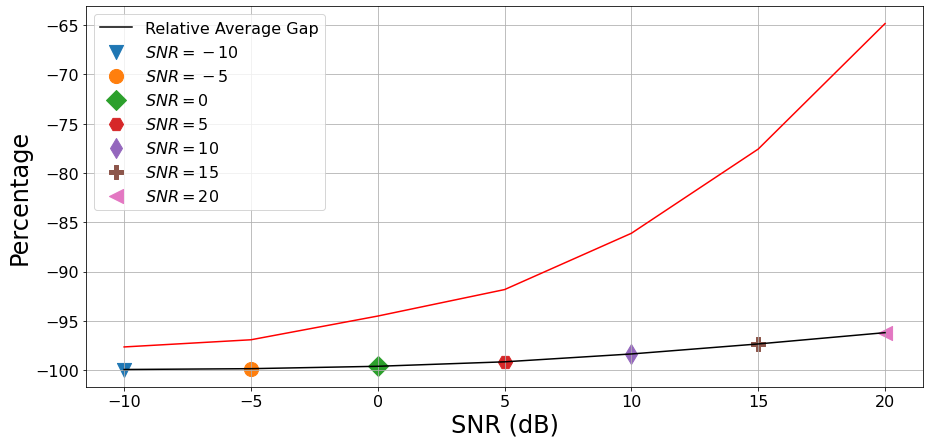

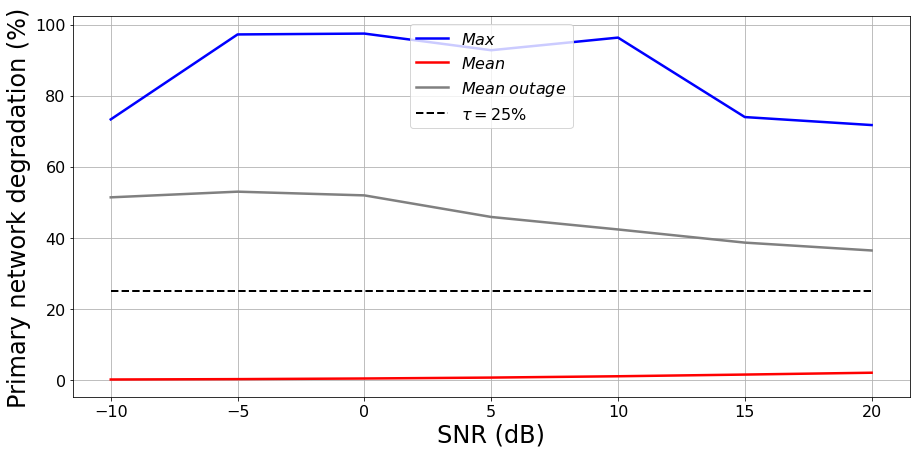

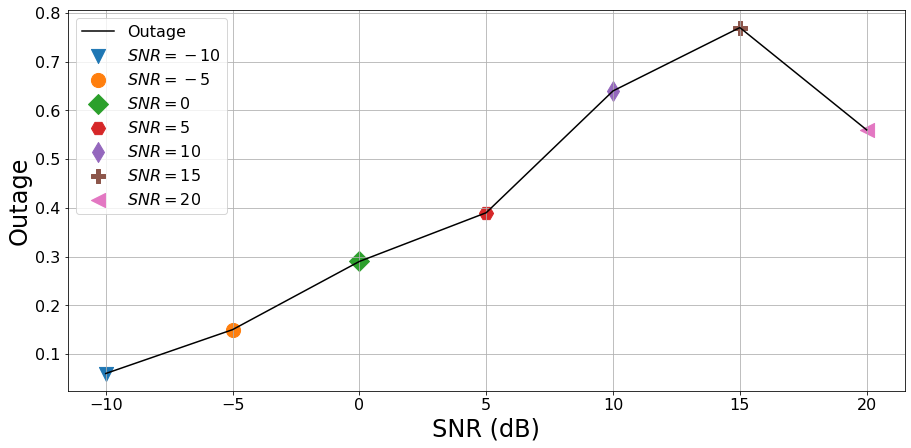

In [218]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)
db_benchmark = rate(dataset[:,0], dataset[:,1], dataset[:,2], dataset[:,3], dataset[:,4], dataset[:,5], dataset[:,6], dataset[:,7], np.sqrt(dataset[:,9]), np.sqrt(dataset[:,10]), np.sqrt(dataset[:,11]))


#db_gap_DNN = np.array([relative_avreage_gap(db_DNN[0,:,8], db_benchmark[:,8]),\
#                       relative_avreage_gap(db_DNN[1,:,8], db_benchmark[:,8]),\
#                       relative_avreage_gap(db_DNN[2,:,8], db_benchmark[:,8]),\
#                       relative_avreage_gap(db_DNN[3,:,8], db_benchmark[:,8]),\
#                       relative_avreage_gap(db_DNN[4,:,8], db_benchmark[:,8]),\
#                       relative_avreage_gap(db_DNN[5,:,8], db_benchmark[:,8]),\
#                       relative_avreage_gap(db_DNN[6,:,8], db_benchmark[:,8])
#                       ])

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [0,1,2,3,4,5,6])


plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')
plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")# bruteforce


Mean_ARPD_DNN, Max_ARPD_DNN, Mean_Outage_ARPD_DNN, Outage_ARPD_DNN = PARD_for_noisy_data_DNN(dataset, DNN_pred)

plot_ARPD(Mean_ARPD_DNN[0:7], Max_ARPD_DNN[:7], Mean_Outage_ARPD_DNN[:7])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[:7], 'Outage', 'SNR (dB)','Outage')


# Trained DNN with SNR = -5

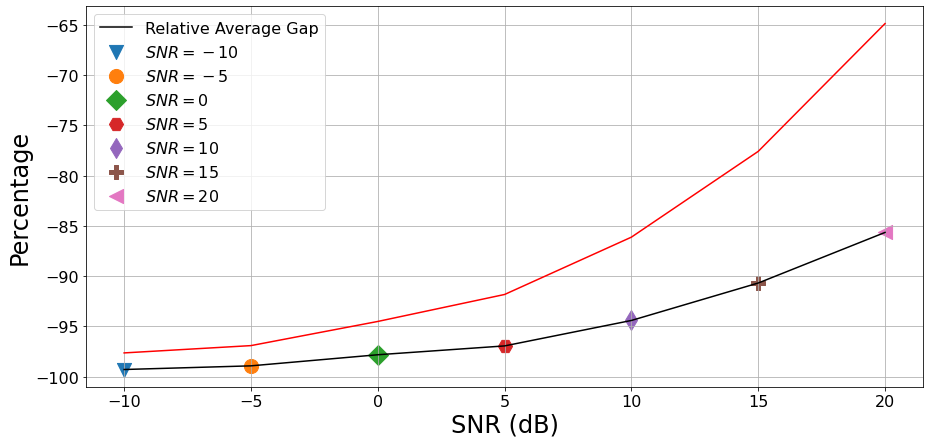

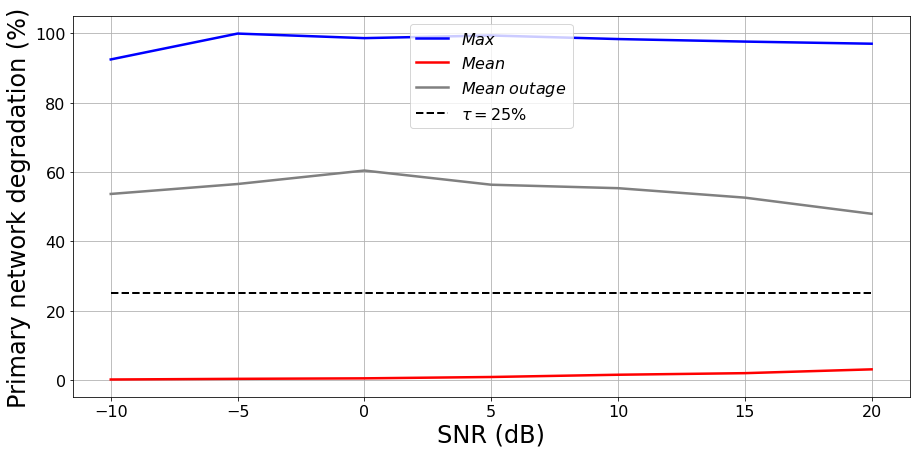

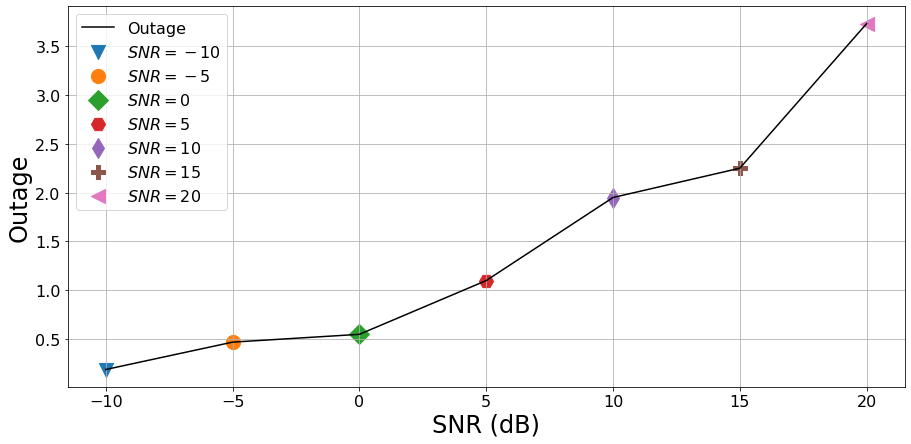

In [219]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [7,8,9,10,11,12,13])


plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')
plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")# bruteforce


plot_ARPD(Mean_ARPD_DNN[7:7*2], Max_ARPD_DNN[7:7*2], Mean_Outage_ARPD_DNN[7:7*2])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[7:7*2], 'Outage', 'SNR (dB)','Outage')





# Trained DNN with SNR = 0 

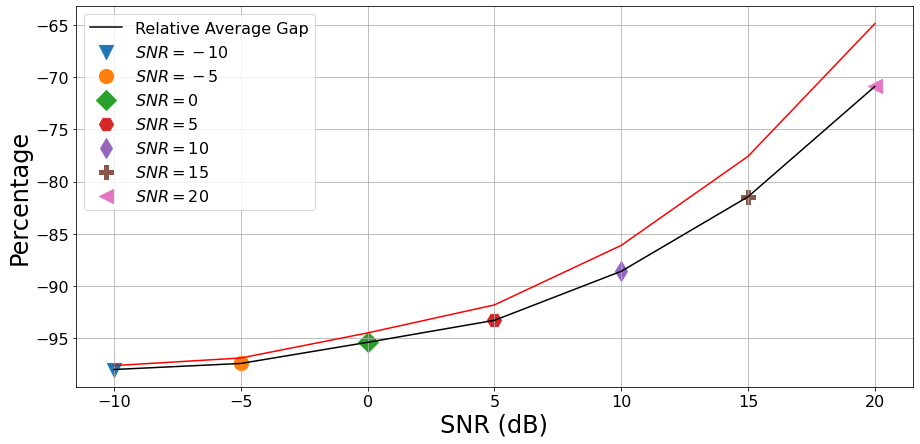

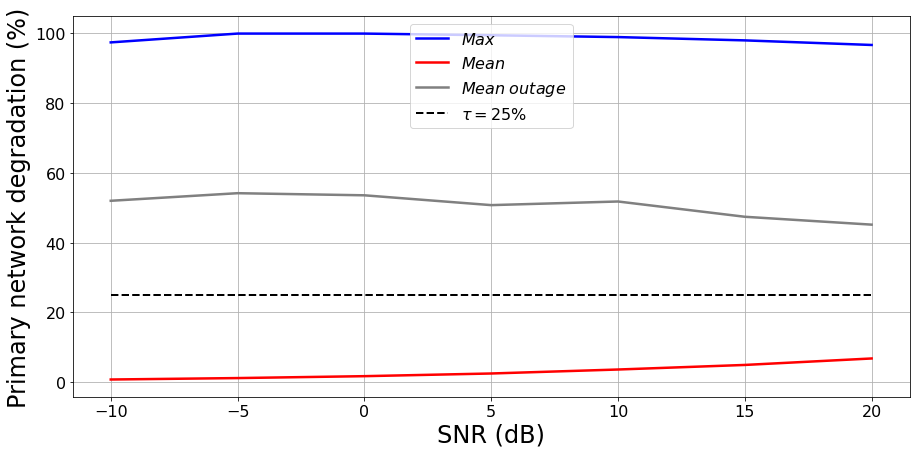

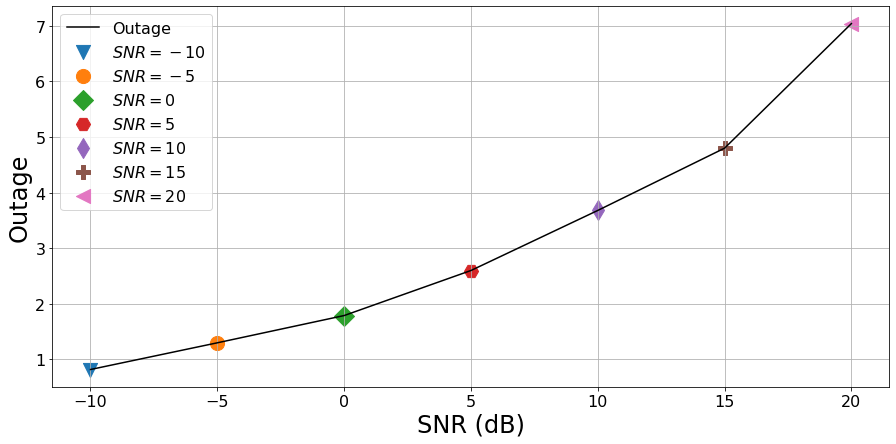

In [212]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [14,15,16,17,18,19,20])


plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')
plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")# bruteforce

plot_ARPD(Mean_ARPD_DNN[7*2:7*3], Max_ARPD_DNN[7*2:7*3], Mean_Outage_ARPD_DNN[7*2:7*3])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[7*2:7*3], 'Outage', 'SNR (dB)','Outage')




# Trained DNN with SNR = 5

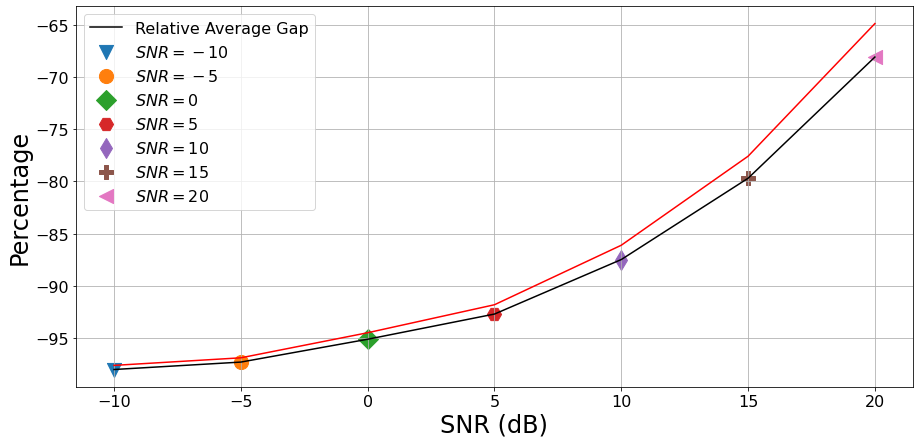

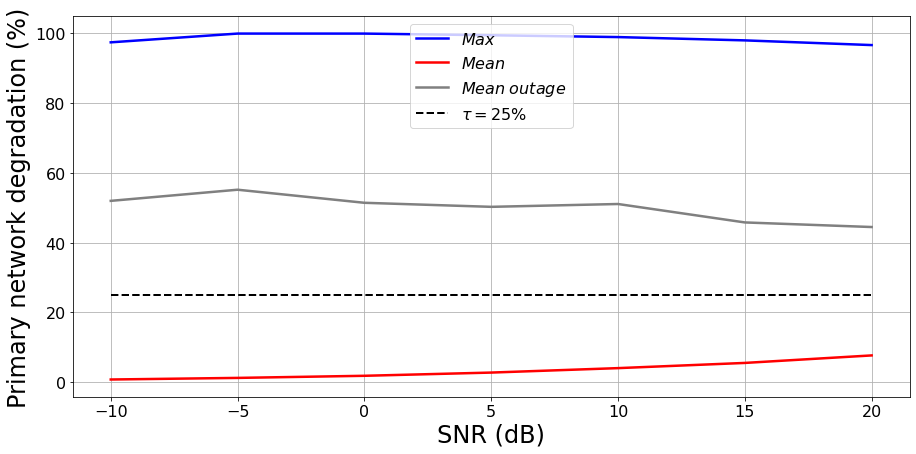

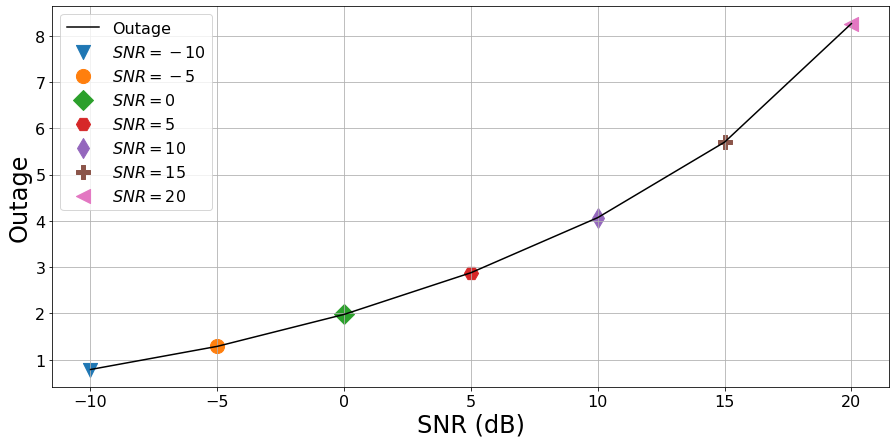

In [213]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [21,22,23,24,25,26,27])


plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')
plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")# bruteforce

plot_ARPD(Mean_ARPD_DNN[7*3:7*4], Max_ARPD_DNN[7*3:7*4], Mean_Outage_ARPD_DNN[7*3:7*4])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[7*3:7*4], 'Outage', 'SNR (dB)','Outage')





# Trained DNN with SNR = 10

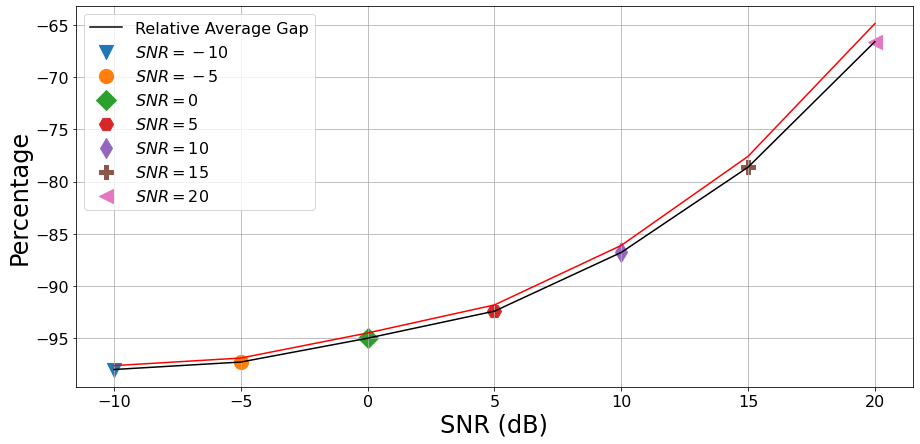

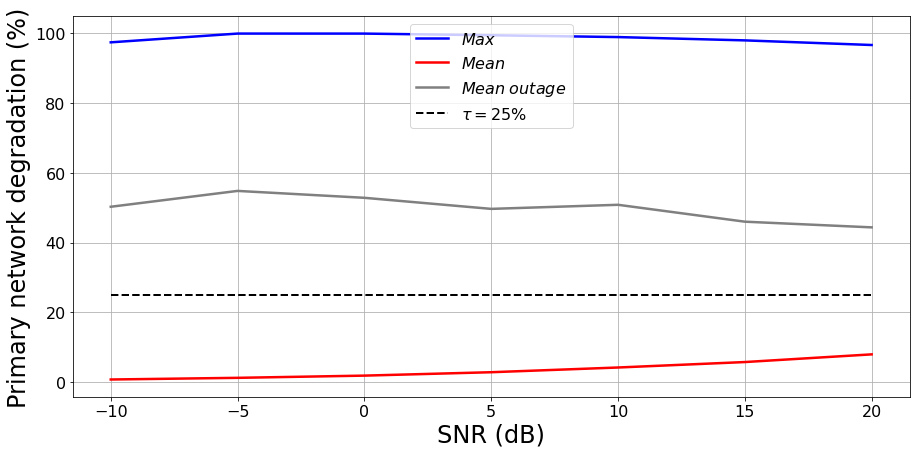

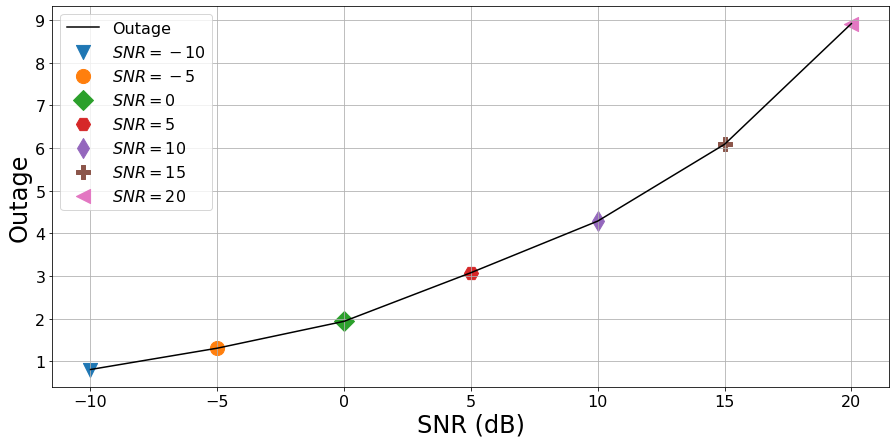

In [214]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [28,29,30,31,32,33,34])


plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')

plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")# bruteforce


plot_ARPD(Mean_ARPD_DNN[7*4:7*5], Max_ARPD_DNN[7*4:7*5], Mean_Outage_ARPD_DNN[7*4:7*5])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[7*4:7*5], 'Outage', 'SNR (dB)','Outage')


# Trained DNN with SNR = 15

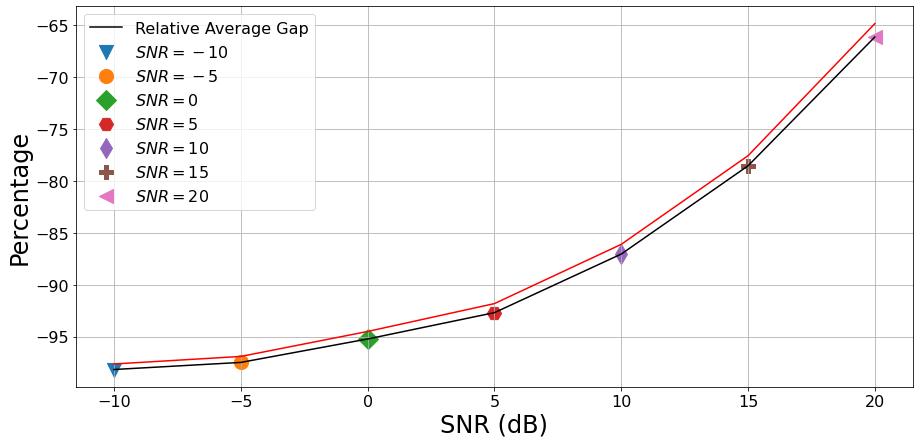

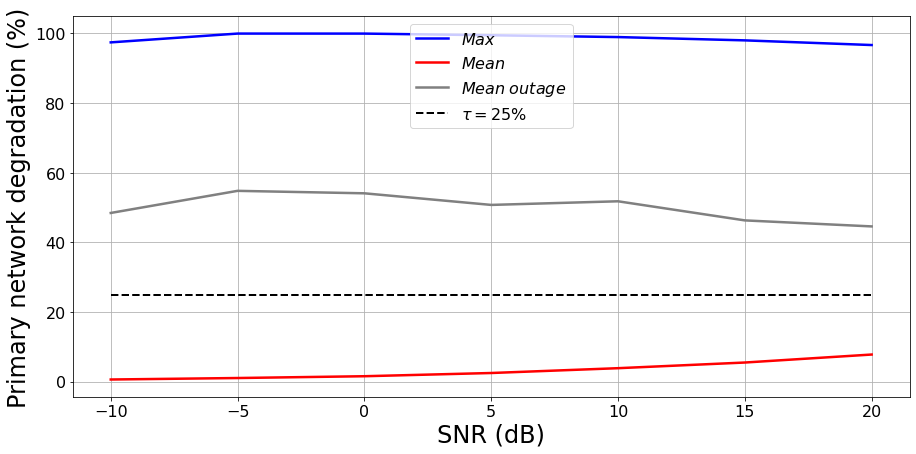

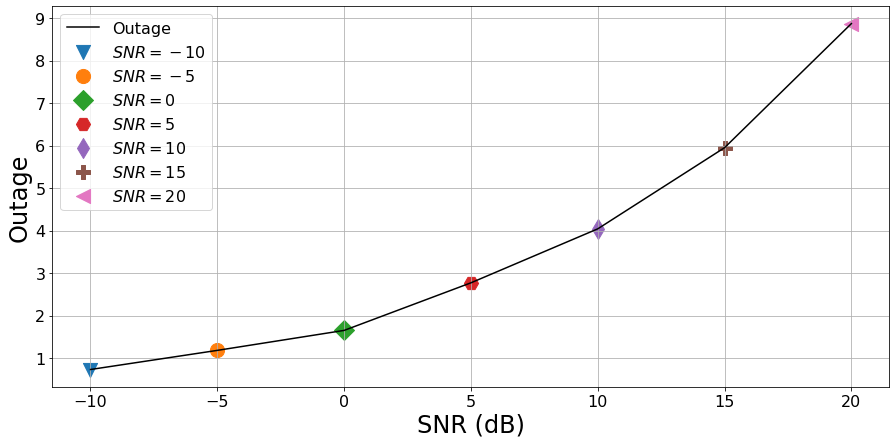

In [215]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [35,36,37,38,39,40,41])


plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')

plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")

plot_ARPD(Mean_ARPD_DNN[7*5:7*6], Max_ARPD_DNN[7*5:7*6], Mean_Outage_ARPD_DNN[7*5:7*6])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[7*5:7*6], 'Outage', 'SNR (dB)','Outage')





# Trained DNN with SNR = 20

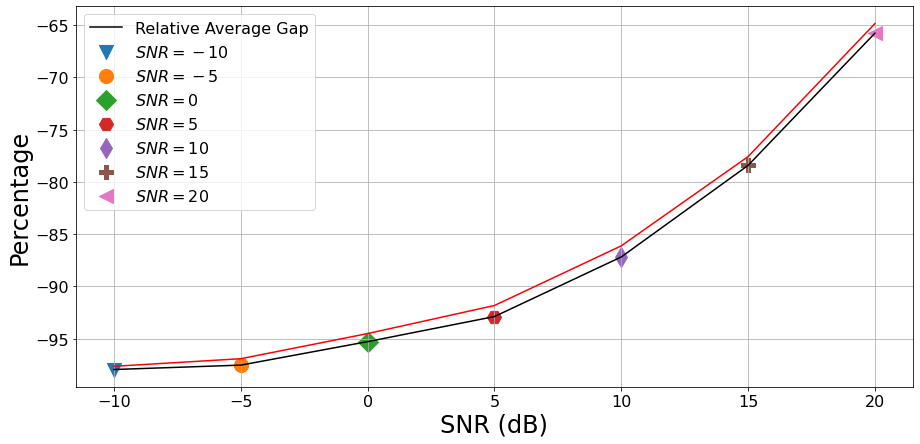

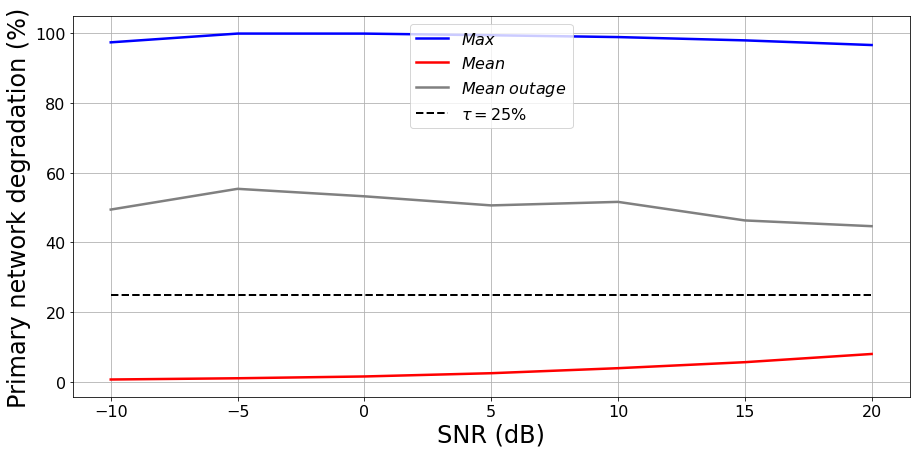

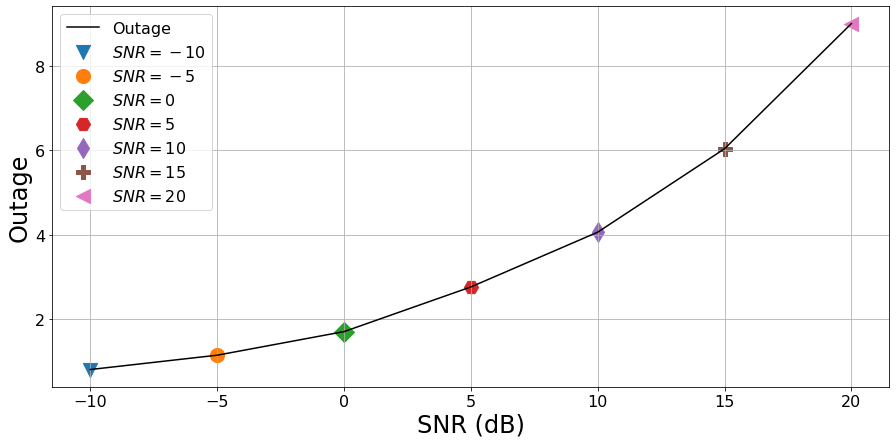

In [216]:
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset, DNN_pred)

db_gap_DNN = db_gap_Dnn(db_DNN, db_benchmark, [42,43,44,45,46,47,48])

db_gap = np.array([relative_avreage_gap(db_bruteforce[0,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[1,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[2,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[3,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[4,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[5,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[6,:,8], db_benchmark[:,8])])
#plt.plot([-10,-5,0,5,10,15,20], db_gap_DNN,color="black")
plot_CSI_Imperfect_Stats(db_gap_DNN, 'Relative Average Gap', 'SNR (dB)','Percentage')
plt.plot([-10,-5,0,5,10,15,20], db_gap*100,color="red")# bruteforce


plot_ARPD(Mean_ARPD_DNN[7*6:7*7], Max_ARPD_DNN[7*6:7*7], Mean_Outage_ARPD_DNN[7*6:7*7])


plot_CSI_Imperfect_Stats(Outage_ARPD_DNN[7*6:7*7], 'Outage', 'SNR (dB)','Outage')





